In [3]:
import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

class GuitarInterface(object):
    
    def __init__(self, audio_device_name="JAM 96k", audio_format=pyaudio.paInt16, channels=1, rate=44100,
                 chunk_size=1024):
        
        # Store some values that we'll need easy access to
        self.audio_format = audio_format
        self.channels = channels
        self.rate = rate
        self.chunk_size = chunk_size
        
        # Initialize the Audio library and device
        self.audio = pyaudio.PyAudio()
        self.audio_device_id = [i for i in range(self.audio.get_device_count()) if self.audio.get_device_info_by_index(i)['name'] == audio_device_name][0]
    
    """
        Capture a number of seconds worth of audio input from the pyAudio device initialized.
        Returns:
            SoundSample: representing the audio captured
    """
    def capture_audio(self, secs=5):
        stream = self.audio.open(format=self.audio_format, channels=self.channels, rate=self.rate, input=True,
                                input_device_index=self.audio_device_id, frames_per_buffer=self.chunk_size)

        frames = stream.read(self.rate * secs)
        
        # stop Recording and properly close the stream
        stream.stop_stream()
        stream.close()
        return SoundSample(frames, secs)
    
    """
        Save a .wav file that can be played back from a SoundSample - 
        Should be saved with the same audio interface that it was created with (so datatypes match)
        
    """
    def save_byte_frames(self, sound_sample, output_filename="audio_output.wav"):
        
        print ("Saving audio sample to: {}".format(output_filename))
        waveFile = wave.open(output_filename, 'wb')
        waveFile.setnchannels(self.channels)
        waveFile.setsampwidth(self.audio.get_sample_size(self.audio_format))
        waveFile.setframerate(self.rate)
        waveFile.writeframes(b''.join(sound_sample.asByteList))
        waveFile.close()
        print("Finished writing file.")
        
    """
        Close the Guitar Interface and make sure that the audio interface is properly terminated
    """
    def close(self):
        self.audio.terminate()
        
        
# A small class to wrap up some useful sound sample conversion methods
# This class doesn't cache the generated lists - this might be a useful optimization at Train time.
class SoundSample(object):
    
    def __init__(self, sample_stream, length, np_datatype='Int16'):
        self.audio_length = length # length in seconds
        self.np_datatype = np_datatype
        self.sample_stream = sample_stream
    
    @property
    def length(self):
        return self.audio_length
    
    @property
    def stream(self):
        return self.sample_stream
    
    @property
    def asList(self):
        data = np.fromstring(self.sample_stream, self.np_datatype)
        return data
    
    @property
    def asByteList(self):
        return [a for a in self.sample_stream]
    
    def show_waveform(self, title=""):
        y, sr = self.asList.astype(float), 44100
        librosa.display.waveplot(y, sr=sr)
        plt.title("Waveform {}".format(title))
        plt.show()
    
    def show_spectrum_plot(self, title=""):
        y, sr = self.asList.astype(float), 44100
        D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
        librosa.display.specshow(D, y_axis='linear')
        plt.colorbar(format='%+2.0f dB')
        plt.title("Linear-frequency power spectrogram {}".format(title))
        plt.show()
    
    def show_chroma_sftp_features(self, title=""):
        y, sr = self.asList.astype(float), 44100
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.title("Chromagram {}".format(title))
        plt.show()
        
    def show_onset_detection(self, title=""):
        y, sr = self.asList.astype(float), 44100

        o_env = librosa.onset.onset_strength(y, sr=sr)
        times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

        D = librosa.stft(y)
        plt.figure()
        ax1 = plt.subplot(2, 1, 1)
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                                  x_axis='time', y_axis='log')
        plt.title("Power spectrogram {}".format(title))
        plt.subplot(2, 1, 2, sharex=ax1)
        plt.plot(times, o_env, label="Onset strength {}".format(title))
        plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
                   linestyle='--', label='Onsets')
        plt.axis('tight')
        plt.legend(frameon=True, framealpha=0.75)
        plt.show()

In [4]:
import time
from IPython.display import clear_output
import uuid

"""
    An annotated sample for use in training or test data
"""
class AnnotatedSample(object):
     
    def __init__(self, sound_sample, annotation_timeline, givenId=None):
        self.sound_sample = sound_sample
        self.annotation_timeline = annotation_timeline
        self._id = givenId
        if self._id is None:
            self._id = uuid.uuid4()
        
        @property
        def id(self):
            return self._id
        
        """
            Annotation Format:
            [{start: 0.0, stop: 2.3, annotation: 'A'}, {...}]
        """
        
class GuitarSampleRecorder(object):
    
    def __init__(self, guitar_interface):
        self.guitar_interface = guitar_interface
        self.annotated_samples = []      
    
    """
        Capture a sequence of notes - this method will do 1 sound recording per note.  Annotated samples will be
        appended to the self.annotated_samples array
        notes: Sequence of notes to be recorded
    """
    def capture_samples(self, targets, duration_secs=5):
        
        for target in targets:
            ann_sample = self._record_sample(target, duration_secs)
            self.annotated_samples.append(ann_sample)
            
        clear_output(wait=True)
        print("Finished Recording")
        
    """
        Record a single sample
    """
    def _record_sample(self, target, duration_secs):
        for i in [2,1]:
            clear_output(wait=True)
            print("Record a {} in {} seconds".format(target, i))
            time.sleep(1)
        
        clear_output(wait=True)
        print("Now Recording... {}".format(target))
        sample = self.guitar_interface.capture_audio(secs=duration_secs)
        return AnnotatedSample(sample, {'start': 0.0, 
                                        'stop': sample.length, 
                                        'annotation': target})
        

# Also want to work out a concise analysis method - so we can analyze samples
# Probably should add logic to the annotated samples for filtering out parts of the audio below some level - 
# or maybe add this functionality to the dataset generation component.

In [5]:
"""
    Let's try out the new training method here - we're going to record 2 notes C and D
"""

gi = GuitarInterface()
rec = GuitarSampleRecorder(gi)
rec.capture_samples(['C', 'C', 'C', 'D', 'D', 'D'])

Finished Recording


/Users/raymondklass/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:81: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


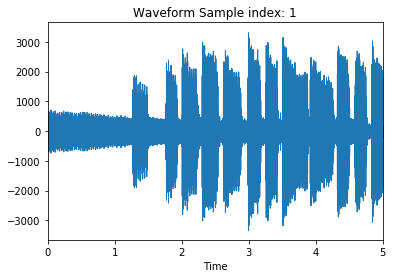

/Users/raymondklass/anaconda2/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


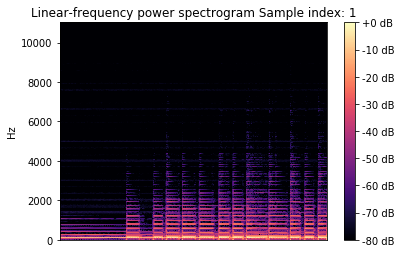

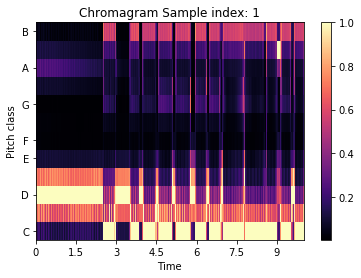

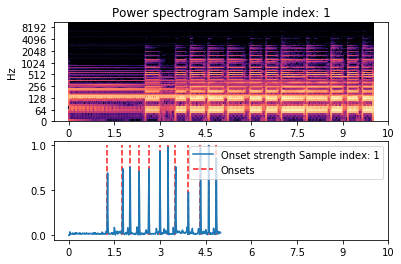

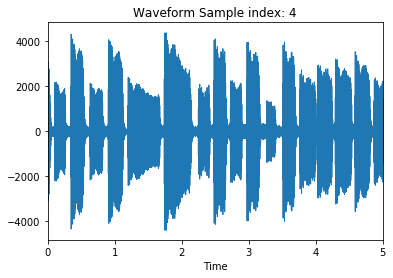

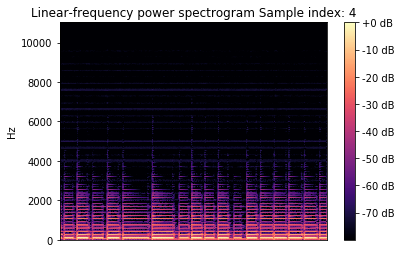

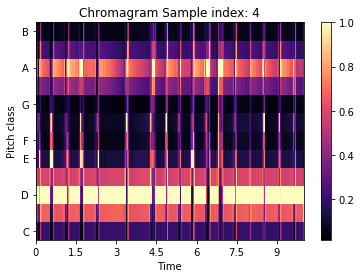

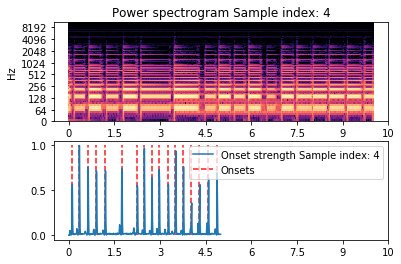

In [8]:
# Add indexes of samples that you would like to see
show_sample_indexes=[1,4]

for sample in show_sample_indexes:
    show_sample(sample, rec)

def show_sample(index, rec):
    title="Sample index: {}".format(index)
    rec.annotated_samples[index].sound_sample.show_waveform(title)
    rec.annotated_samples[index].sound_sample.show_spectrum_plot(title)
    rec.annotated_samples[index].sound_sample.show_chroma_sftp_features(title)
    rec.annotated_samples[index].sound_sample.show_onset_detection(title)

In [ ]:
# rec -> GuitarSampleRecorder
# rec.annotated_samples -> annotated samples with sound_sample and annotated_timeline

import os
import cPickle as pickle

# So let's have some simple dataset logic here
class SampleDataset(object):
    
    def __init__(self, index_file_name="index.pickle"):
        self.annotated_samples = []
        self.index = DatasetIndex()
        selk.index_file_name = index_file_name
        
    def add_samples(self, samples):
        self.annotated_samples += samples
    
    def save_dataset(self, dest_folder):
        # First we should create and save an index file - 
        # Then we will need to have both the annotations and the files in an orderly fashion
        fh = FolderHelper(dest_folder, self.index_file_name)
        
    
    def _save_index(self, index_content):
        # Pickle and save the dataset index
        
        

class DatasetIndex(object):
    def __init__(self):
        self.index = {}
    
    def load_from_file(self, index_file):
        # This method loads a new index file from location - use append method to add indexes
        # un-pickle file, and replace the self.index with it...
        
    
    def add_sample(self, sample, dest_folder):
        # The index only needs to have the media ID and folder - the rest of the file locations can
        # be inferred - annotations.pickle, media.mp4
        self.index[sample.id] = os.path.join(dest_folder, sample.id)
        
    def remove_sample(self, sample_id):
        self.index.pop(sample_id, None)
        
    def update_sample(self, sample_id, **updates):
        if sample_id in self.index:
            self.index[sample_id].update(updates)
            
        
class FolderHelper(object):
    def __init__(self, folder, index_file_name="index.pickle"):
        self.folder = folder
        self.index_file_name
        
    @property
    def exists(self):
        # returns a boolean - whether the folder exists
        os.path.isdir(self.folder)
    
    @property
    def has_index(self):
        # returns a boolean - whether an index file exists in a given folder
        os.path.isfile(os.path.join(self.folder, self.index_file_name)) 
        